<a href="https://colab.research.google.com/github/drlee1218/ChosenOne/blob/main/IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import os
import sys
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, precision_score
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report

# Environment

In [ ]:
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Torch: {torch.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Pandas: 2.2.2
Numpy: 2.0.2
Torch: 2.6.0+cu124
TensorFlow: 2.18.0
Keras: 3.8.0
Matplotlib: 3.10.0
Scikit-learn: 1.6.1
Device: cuda


# Prepare the Data

## Download the Datasets

In [ ]:
nslkdd_path = kagglehub.dataset_download("hassan06/nslkdd")
cic_ids_path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

print("Path to nslkdd_path dataset files:", nslkdd_path)
print("Path to cic_ids_path dataset files:", cic_ids_path)

Path to nslkdd_path dataset files: /kaggle/input/nslkdd
Path to cic_ids_path dataset files: /kaggle/input/network-intrusion-dataset


## NSL-KDD 2009 Dataset

***Improvements to the KDD'99 data set ***

The NSL-KDD data set has the following advantages over the original KDD data set:
It does not include redundant records in the train set and there are no duplicate records in the proposed test sets.


  @INPROCEEDINGS{5356528,\
  author={Tavallaee, Mahbod and Bagheri, Ebrahim and Lu, Wei and Ghorbani, Ali A.},\
  booktitle={2009 IEEE Symposium on Computational Intelligence for Security and Defense Applications},\
  title={A detailed analysis of the KDD CUP 99 data set},\
  year={2009},\
  volume={},\
  number={},\
  pages={1-6},\
  doi={10.1109/CISDA.2009.5356528}}\
  https://www.ee.torontomu.ca/~bagheri/papers/cisda.pdf

### Initial Data Exploration

In [ ]:
os.listdir(nslkdd_path)

['KDDTest+.arff',
 'KDDTest-21.arff',
 'KDDTest1.jpg',
 'KDDTrain+.txt',
 'KDDTrain+_20Percent.txt',
 'KDDTest-21.txt',
 'KDDTest+.txt',
 'KDDTrain+.arff',
 'index.html',
 'nsl-kdd',
 'KDDTrain+_20Percent.arff',
 'KDDTrain1.jpg']

In [ ]:
nslkdd_train_data = pd.read_csv(os.path.join(nslkdd_path,'KDDTrain+.txt'), header=None)
nslkdd_test_data = pd.read_csv(os.path.join(nslkdd_path, 'KDDTest+.txt'), header=None)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
nslkdd_train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
# https://kdd.ics.uci.edu/databases/kddcup99/task.html
nslkdd_columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

nslkdd_train_data.columns = nslkdd_columns
nslkdd_test_data.columns = nslkdd_columns

In [ ]:
nslkdd_train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
nslkdd_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
nslkdd_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [ ]:
nslkdd_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [ ]:
def unique_values(df, columns):
    """Prints unique values and their counts for specific columns in the DataFrame."""

    for column_name in columns:
        print(f"Column: {column_name}\n{'-'*30}")
        unique_vals = df[column_name].unique()
        value_counts = df[column_name].value_counts()
        print(f"Unique Values ({len(unique_vals)}): {unique_vals}\n")
        print(f"Value Counts:\n{value_counts}\n{'='*40}\n")

In [ ]:
#unique_values(nslkdd_train_data, nslkdd_columns)

There are **41 features**, along with a label column and a difficulty level column, making a total of 43 columns.\
The difficulty level column shows how hard it is to calssify this data correclty. The higher the value the more classifiers classified this record correctly.

### Preperate Features

#### Check for Null and Infinity values and duplicates

In [ ]:
nslkdd_null_columns = nslkdd_train_data.columns[nslkdd_train_data.isnull().any()]
print(nslkdd_null_columns)

Index([], dtype='object')


In [ ]:
all(nslkdd_train_data.isnull().sum() == 0)

True

In [ ]:
nslkdd_inf_columns = nslkdd_train_data.select_dtypes(include=['float64']).columns[np.isinf(nslkdd_train_data.select_dtypes(include=['float64'])).any(axis=0)]
print(nslkdd_inf_columns)

Index([], dtype='object')


In [ ]:
nslkdd_duplicates = nslkdd_train_data[nslkdd_train_data.duplicated()]
print(nslkdd_duplicates)

Empty DataFrame
Columns: [duration, protocol_type, service, flag, src_bytes, dst_bytes, land, wrong_fragment, urgent, hot, num_failed_logins, logged_in, num_compromised, root_shell, su_attempted, num_root, num_file_creations, num_shells, num_access_files, num_outbound_cmds, is_host_login, is_guest_login, count, srv_count, serror_rate, srv_serror_rate, rerror_rate, srv_rerror_rate, same_srv_rate, diff_srv_rate, srv_diff_host_rate, dst_host_count, dst_host_srv_count, dst_host_same_srv_rate, dst_host_diff_srv_rate, dst_host_same_src_port_rate, dst_host_srv_diff_host_rate, dst_host_serror_rate, dst_host_srv_serror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, attack, level]
Index: []


#### Encode non-numerical values into numbers

In [ ]:
nslkdd_full_data = pd.concat([nslkdd_train_data, nslkdd_test_data], ignore_index=True)

In [ ]:
non_numeric_cols = nslkdd_full_data.select_dtypes(exclude=['int', 'float']).columns
non_numeric_cols

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')

In [ ]:
nslkdd_label_encoders = {}
for column in non_numeric_cols:
    le = LabelEncoder()
    nslkdd_full_data[column] = le.fit_transform(nslkdd_full_data[column])
    nslkdd_label_encoders[column] = le

#### Create Train-/ Testsplit

In [ ]:
nslkdd_X = nslkdd_full_data.drop(['attack', 'level'], axis=1)
nslkdd_y = nslkdd_full_data['attack']

nslkdd_X_train, nslkdd_X_test, nslkdd_y_train, nslkdd_y_test = train_test_split(nslkdd_X, nslkdd_y, test_size=0.2, random_state=42)

In [ ]:
# Normalize the values
scaler = MinMaxScaler()
nslkdd_X_train_scaled = scaler.fit_transform(nslkdd_X_train)
nslkdd_X_test_scaled = scaler.transform(nslkdd_X_test)

In [ ]:
nslkdd_X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,20,9,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,44,9,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,24,9,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,24,9,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
pd.DataFrame(nslkdd_X_train_scaled, columns=[x for x in nslkdd_columns if x not in ['attack', 'level']]).head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.5,0.782609,0.9,9.036468e-07,2.534472e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.160784,0.650980,0.63,0.15,0.02,0.02,0.0,0.0,0.0,0.0
1,0.0,0.5,0.347826,0.9,2.579778e-07,3.237559e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.109804,1.000000,1.00,0.00,0.04,0.02,0.0,0.0,0.0,0.0
2,0.0,0.5,0.782609,0.9,6.674088e-07,2.519204e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.815686,0.960784,0.96,0.01,0.00,0.01,0.0,0.0,0.0,0.0
3,0.0,0.5,0.072464,0.5,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.007828,1.0,1.0,0.0,0.0,0.02,0.06,0.0,1.000000,0.066667,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
4,0.0,0.5,0.579710,0.5,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452055,0.003914,1.0,1.0,0.0,0.0,0.01,0.07,0.0,1.000000,0.007843,0.01,0.08,0.00,0.00,1.0,1.0,0.0,0.0


### Feature Selection

Using all features gives the best result ->
https://www.researchgate.net/publication/282068871_Feature_selection_and_intrusion_classification_in_NSL-KDD_cup_99_dataset_employing_SVMs

In [ ]:
nslkdd_pca = PCA(n_components=min(10, nslkdd_X_train_scaled.shape[1]))
nslkdd_pca.fit(nslkdd_X_train_scaled)

nslkdd_components = pd.DataFrame(
    np.abs(nslkdd_pca.components_),
    columns=nslkdd_X_train.columns
)

nslkdd_feature_importance_pca = nslkdd_components.mean(axis=0).sort_values(ascending=False)

nslkdd_explained_variance_ratio = nslkdd_pca.explained_variance_ratio_
nslkdd_feature_importance_weighted = (nslkdd_components.T @ nslkdd_explained_variance_ratio).sort_values(ascending=False)

nslkdd_feature_importance_pca_df = pd.DataFrame({
    'feature': nslkdd_feature_importance_weighted.index,
    'importance': nslkdd_feature_importance_weighted.values
})

print(nslkdd_feature_importance_pca_df)

                        feature    importance
0                     logged_in  2.716917e-01
1            dst_host_srv_count  2.384618e-01
2               srv_serror_rate  2.340978e-01
3                   serror_rate  2.333293e-01
4      dst_host_srv_serror_rate  2.299630e-01
5          dst_host_serror_rate  2.281173e-01
6        dst_host_same_srv_rate  2.274402e-01
7                 same_srv_rate  2.147472e-01
8                dst_host_count  1.790675e-01
9                          flag  1.539868e-01
10              srv_rerror_rate  1.383231e-01
11                  rerror_rate  1.377761e-01
12     dst_host_srv_rerror_rate  1.343694e-01
13         dst_host_rerror_rate  1.234166e-01
14                        count  1.034818e-01
15  dst_host_same_src_port_rate  1.014119e-01
16                      service  9.400097e-02
17           srv_diff_host_rate  8.706015e-02
18       dst_host_diff_srv_rate  7.408416e-02
19                diff_srv_rate  7.094434e-02
20                protocol_type  5

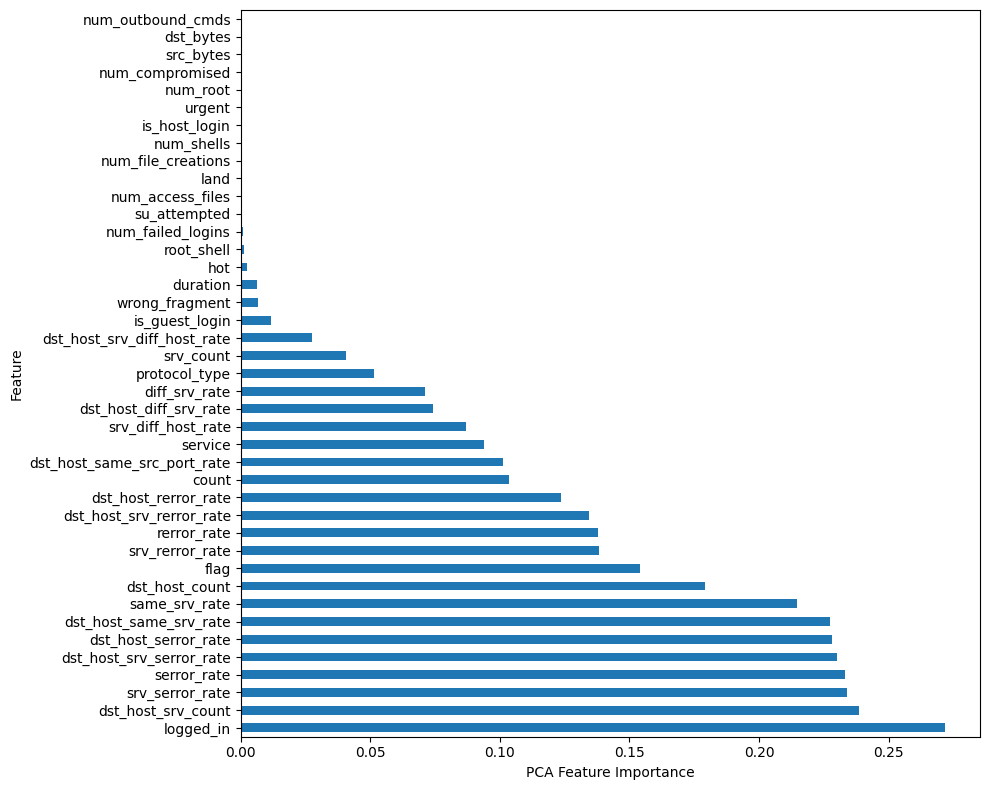

In [ ]:
nslkdd_feature_importance_pca_df.plot(
    x='feature',
    y='importance',
    kind='barh',
    legend=False,
    figsize=(10, 8)
)
plt.xlabel("PCA Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Summary
To summarize we checked for null, infinity and duplicate values and encoded every column as numbers (with LabelEncoder) and normalized the numbers. Last but not least we checked the feature importance.

In [ ]:
# Data we can continue with:
# -> nslkdd_X_train_scaled -> nslkdd_y_train
# -> nslkdd_X_test_scaled -> nslkdd_y_test

nslkdd_mapping = {cls: idx for idx, cls in enumerate(nslkdd_label_encoders['attack'].classes_)}
print(nslkdd_mapping)

{'apache2': 0, 'back': 1, 'buffer_overflow': 2, 'ftp_write': 3, 'guess_passwd': 4, 'httptunnel': 5, 'imap': 6, 'ipsweep': 7, 'land': 8, 'loadmodule': 9, 'mailbomb': 10, 'mscan': 11, 'multihop': 12, 'named': 13, 'neptune': 14, 'nmap': 15, 'normal': 16, 'perl': 17, 'phf': 18, 'pod': 19, 'portsweep': 20, 'processtable': 21, 'ps': 22, 'rootkit': 23, 'saint': 24, 'satan': 25, 'sendmail': 26, 'smurf': 27, 'snmpgetattack': 28, 'snmpguess': 29, 'spy': 30, 'sqlattack': 31, 'teardrop': 32, 'udpstorm': 33, 'warezclient': 34, 'warezmaster': 35, 'worm': 36, 'xlock': 37, 'xsnoop': 38, 'xterm': 39}


## CIC-IDS- 2017 Dataset

https://www.unb.ca/cic/datasets/ids-2018.html \
@article{article,\
author = {Panwar, Lokesh and Panwar, Shailesh},\
year = {2019},\
month = {09},\
pages = {2195},\
title = {Implementation of Machine Learning Algorithms on CICIDS-2017 Dataset for Intrusion Detection using WEKA},\
volume = {8},\
doi = {10.35940/ijrte.C4587.098319}\
}

### Initial Data Exploration

In [ ]:
os.listdir(cic_ids_path)

['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

In [ ]:
cic_ids_file_paths = [os.path.join(cic_ids_path,file_path) for file_path in os.listdir(cic_ids_path)]
cic_ids_dfs =[]
for cic_ids_file_path in cic_ids_file_paths:
    df=pd.read_csv(cic_ids_file_path)
    cic_ids_dfs.append(df)
cic_ids_data = pd.concat(cic_ids_dfs, ignore_index=True)

In [ ]:
nslkdd_train_data.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.0,1.0,0.0,0.0,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.0,1.0,0.0,0.0,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [ ]:
cic_ids_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,976,0,158.045455,312.675250,7595.104640,67.122468,15075.50000,104051.399700,948537,0,1266342,31658.550,159355.2595,996324,2,317671,7387.697674,19636.44809,104616,1,0,0,0,0,1328,1424,32.376720,34.745748,0,976,111.837209,239.686848,57449.78495,0,0,0,1,0,0,0,0,1,113.152941,64.975610,158.045455,1328,0,0,0,0,0,0,41,2664,44,6954,29200,243,24,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,976,0,158.045455,312.675250,7289.936810,64.425518,15706.58333,104861.870100,955790,1,1319353,32983.825,159247.9008,996423,1,363429,8451.837209,21337.26261,104815,1,0,0,0,0,1328,1424,31.075838,33.349680,0,976,111.837209,239.686848,57449.78495,0,0,0,1,0,0,0,0,1,113.152941,64.975610,158.045455,1328,0,0,0,0,0,0,41,2664,44,6954,29200,243,24,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,12500.000000,160.00000,0.000000,160,160,0,0.000,0.0000,0,0,0,0.000000,0.00000,0,0,0,0,0,0,32,32,6250.000000,6250.000000,0,0,0.000000,0.000000,0.00000,0,0,0,0,1,1,0,0,1,0.000000,0.000000,0.000000,32,0,0,0,0,0,0,1,0,1,0,290,243,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,976,0,157.952381,319.121427,7182.267884,63.675308,15896.19512,106554.899000,956551,0,1303488,32587.200,160397.0499,997357,1,346851,8459.780488,23962.23892,138295,0,0,0,0,0,1328,1360,31.454068,32.221240,0,976,111.452381,241.642791,58391.23867,0,0,0,1,0,0,0,0,1,112.795181,66.536585,157.952381,1328,0,0,0,0,0,0,41,2728,42,6634,29200,243,24,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,38961.038960,38.50000,14.849242,49,28,0,0.000,0.0000,0,0,49,49.000000,0.00000,49,49,0,0,0,0,32,64,12987.012990,25974.025970,0,0,0.000000,0.000000,0.00000,0,0,0,0,1,1,0,0,2,0.000000,0.000000,0.000000,32,0,0,0,0,0,0,1,0,2,0,243,290,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
cic_ids_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
cic_ids_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.000000e+00,53.000000,80.000000,4.430000e+02,6.553500e+04
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-1.300000e+01,155.000000,31316.000000,3.204828e+06,1.200000e+08
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.000000e+00,2.000000,2.000000,5.000000e+00,2.197590e+05
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.000000e+00,1.000000,2.000000,4.000000e+00,2.919220e+05
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.000000e+00,12.000000,62.000000,1.870000e+02,1.290000e+07
Total Length of Bwd Packets,2830743.0,1.616264e+04,2.263088e+06,0.000000e+00,0.000000,123.000000,4.820000e+02,6.554530e+08
Fwd Packet Length Max,2830743.0,2.075999e+02,7.171848e+02,0.000000e+00,6.000000,37.000000,8.100000e+01,2.482000e+04
Fwd Packet Length Min,2830743.0,1.871366e+01,6.033935e+01,0.000000e+00,0.000000,2.000000,3.600000e+01,2.325000e+03
Fwd Packet Length Mean,2830743.0,5.820194e+01,1.860912e+02,0.000000e+00,6.000000,34.000000,5.000000e+01,5.940857e+03
Fwd Packet Length Std,2830743.0,6.891013e+01,2.811871e+02,0.000000e+00,0.000000,0.000000,2.616295e+01,7.125597e+03


There are **78 features**, along with a label column, making a total of 79 columns.

### Preperate Features

#### Check for Null and Infinity values and duplicates

In [ ]:
cic_ids_null_columns = cic_ids_data.columns[cic_ids_data.isnull().any()]
print(cic_ids_null_columns)

Index(['Flow Bytes/s'], dtype='object')


In [ ]:
cic_ids_data['Flow Bytes/s'].head()

,Flow Bytes/s
0,7595.104640
1,7289.936810
2,0.000000
3,7182.267884
4,0.000000


In [ ]:
cic_ids_data['Flow Bytes/s'].describe().T

,Flow Bytes/s
count,2.829385e+06
mean,inf
std,NaN
min,-2.610000e+08
25%,1.193197e+02
50%,4.595549e+03
75%,1.666667e+05
max,inf


In [ ]:
cic_ids_data['Flow Bytes/s'].mean()

np.float64(inf)

In [ ]:
sys.float_info.max

1.7976931348623157e+308

In [ ]:
cic_ids_data = cic_ids_data.fillna(sys.float_info.max)

In [ ]:
all(cic_ids_data.isnull().sum() == 0)

True

In [ ]:
cic_ids_inf_columns = cic_ids_data.select_dtypes(include=['float64']).columns[np.isinf(cic_ids_data.select_dtypes(include=['float64'])).any(axis=0)]
print(cic_ids_inf_columns)

Index(['Flow Bytes/s', ' Flow Packets/s'], dtype='object')


In [ ]:
np.isneginf(cic_ids_data.select_dtypes(include=['float64']).values).any()

np.False_

In [ ]:
np.isposinf(cic_ids_data.select_dtypes(include=['float64']).values).any()

np.True_

In [ ]:
cic_ids_data['Flow Bytes/s'].describe().T

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,Flow Bytes/s
count,2.830743e+06
mean,inf
std,NaN
min,-2.610000e+08
25%,1.193427e+02
50%,4.603446e+03
75%,1.666667e+05
max,inf


In [ ]:
sum(np.isposinf(cic_ids_data['Flow Bytes/s']))

1509

In [ ]:
sum(np.isposinf(cic_ids_data[' Flow Packets/s']))

2867

In [ ]:
cic_ids_data[' Flow Packets/s'].describe().T

,Flow Packets/s
count,2.830743e+06
mean,inf
std,NaN
min,-2.000000e+06
25%,3.446226e+00
50%,1.106684e+02
75%,2.325581e+04
max,inf


In [ ]:
cic_ids_data = cic_ids_data.replace([np.inf], sys.float_info.max)

In [ ]:
inf_columns = cic_ids_data.select_dtypes(include=['float64']).columns[np.isinf(cic_ids_data.select_dtypes(include=['float64'])).any(axis=0)]
print(inf_columns)

Index([], dtype='object')


In [ ]:
cic_ids_duplicates = cic_ids_data[cic_ids_data.duplicated()]
print(len(cic_ids_duplicates))

308381


In [ ]:
cic_ids_data = cic_ids_data.drop_duplicates()

In [ ]:
print(len(cic_ids_data[cic_ids_data.duplicated()]))

0


#### Encode non-numerical values into numbers

In [ ]:
cic_ids_non_numeric_cols = cic_ids_data.select_dtypes(exclude=['int', 'float']).columns
cic_ids_non_numeric_cols

Index([' Label'], dtype='object')

In [ ]:
cic_ids_label_encoders = {}
for column in cic_ids_non_numeric_cols:
    le = LabelEncoder()
    cic_ids_data[column] = le.fit_transform(cic_ids_data[column])
    cic_ids_label_encoders[column] = le

In [ ]:
cic_ids_X = cic_ids_data.drop([' Label'], axis=1)
cic_ids_y = cic_ids_data[' Label']

cic_ids_X_train, cic_ids_X_test, cic_ids_y_train, cic_ids_y_test = train_test_split(cic_ids_X, cic_ids_y, test_size=0.2, random_state=42)

In [ ]:
# Normalize the values
scaler = MinMaxScaler()
cic_ids_X_train_scaled = scaler.fit_transform(cic_ids_X_train)
cic_ids_X_test_scaled = scaler.transform(cic_ids_X_test)

In [ ]:
pd.DataFrame(cic_ids_X_train_scaled, columns=[x for x in cic_ids_data.columns if x not in [' Label']]).head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.001221,0.000002,0.000009,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.451861e-300,1.120522e-302,9.791666e-07,0.000002,0.000002,1.500000e-07,1.741667e-06,8.708333e-07,0.000002,1.708333e-06,1.333333e-07,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.999856,0.994592,4.784689e-03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000009,0.000000,0.000000,0.000000e+00,0.003845,0.00000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000809,0.212172,0.000014,0.000014,0.000012,9.489620e-07,0.001894,0.013083,0.006481,0.001377,0.011913,0.035912,0.026808,0.007257,1.451861e-300,1.112537e-302,3.031039e-02,0.113155,0.211667,1.333333e-07,2.116667e-01,7.063689e-02,0.174134,2.116667e-01,1.166667e-07,2.116667e-01,7.063705e-02,0.174133,2.116667e-01,2.500000e-08,0.0,0.0,0.0,0.0,0.999856,0.994592,5.236841e-08,7.855261e-08,0.020718,0.008340,0.026836,0.015362,0.000236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006410,0.025878,0.006481,0.026808,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000014,0.000012,0.000014,9.489620e-07,0.000000,0.00000,0.000014,1.0,0.000285,0.0,0.000285,0.000285,0.211667,0.0,0.211667,0.211667
2,0.000809,0.000255,0.000000,0.000003,0.000006,2.486830e-07,0.003263,0.035325,0.013634,0.000000,0.009381,0.056285,0.028101,0.000000,1.451905e-300,1.112573e-302,2.552750e-04,0.000000,0.000255,2.552833e-04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,9.999999e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.999856,0.994592,1.088613e-05,1.632920e-05,0.055939,0.006567,0.032463,0.010006,0.000100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006410,0.041738,0.013634,0.028101,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000006,0.000003,2.486830e-07,0.000000,0.00000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000809,0.000260,0.000005,0.000007,0.000013,5.004172e-07,0.003304,0.035761,0.013803,0.000000,0.009438,0.056630,0.028273,0.000000,1.451949e-300,1.112608e-302,8.662499e-05,0.000212,0.000259,1.416667e-07,2.500000e-08,2.500000e-08,0.000000,2.500000e-08,1.250000e-07,4.083333e-07,4.083333e-07,0.000000,4.083333e-07,4.083333e-07,0.0,0.0,0.0,0.0,0.999856,0.994592,2.140457e-05,3.210685e-05,0.056630,0.006608,0.034401,0.009492,0.000090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006410,0.036858,0.013803,0.028273,0.999856,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.000013,0.000007,5.004172e-07,0.000000,0.00000,0.000005,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.001221,0.002079,0.000009,0.000021,0

### Feature Selection

In [ ]:
cic_ids_pca = PCA(n_components=min(10, cic_ids_X_train_scaled.shape[1]))
cic_ids_pca.fit(cic_ids_X_train_scaled)

cic_ids_components = pd.DataFrame(
    np.abs(cic_ids_pca.components_),
    columns=cic_ids_X_train.columns
)

cic_ids_feature_importance_pca = cic_ids_components.mean(axis=0).sort_values(ascending=False)

cic_ids_explained_variance_ratio = cic_ids_pca.explained_variance_ratio_
cic_ids_feature_importance_weighted = (cic_ids_components.T @ cic_ids_explained_variance_ratio).sort_values(ascending=False)

cic_ids_feature_importance_pca_df = pd.DataFrame({
    'feature': cic_ids_feature_importance_weighted.index,
    'importance': cic_ids_feature_importance_weighted.values
})

print(cic_ids_feature_importance_pca_df)

                         feature    importance
0                 PSH Flag Count  2.994414e-01
1                 ACK Flag Count  2.833228e-01
2                 URG Flag Count  2.130148e-01
3               Destination Port  2.037081e-01
4                  Flow Duration  1.853416e-01
5                  Fwd IAT Total  1.850490e-01
6                  Bwd IAT Total  1.574710e-01
7                       Idle Max  1.467857e-01
8                    Fwd IAT Max  1.458336e-01
9                   Flow IAT Max  1.454053e-01
10                     Idle Mean  1.431862e-01
11                      Idle Min  1.399683e-01
12        Init_Win_bytes_forward  1.310384e-01
13                SYN Flag Count  1.146434e-01
14                 Fwd PSH Flags  1.146434e-01
15                   Bwd IAT Max  8.947763e-02
16             Packet Length Std  8.725774e-02
17                FIN Flag Count  8.633735e-02
18                   Fwd IAT Std  7.853043e-02
19         Bwd Packet Length Max  7.207762e-02
20          A

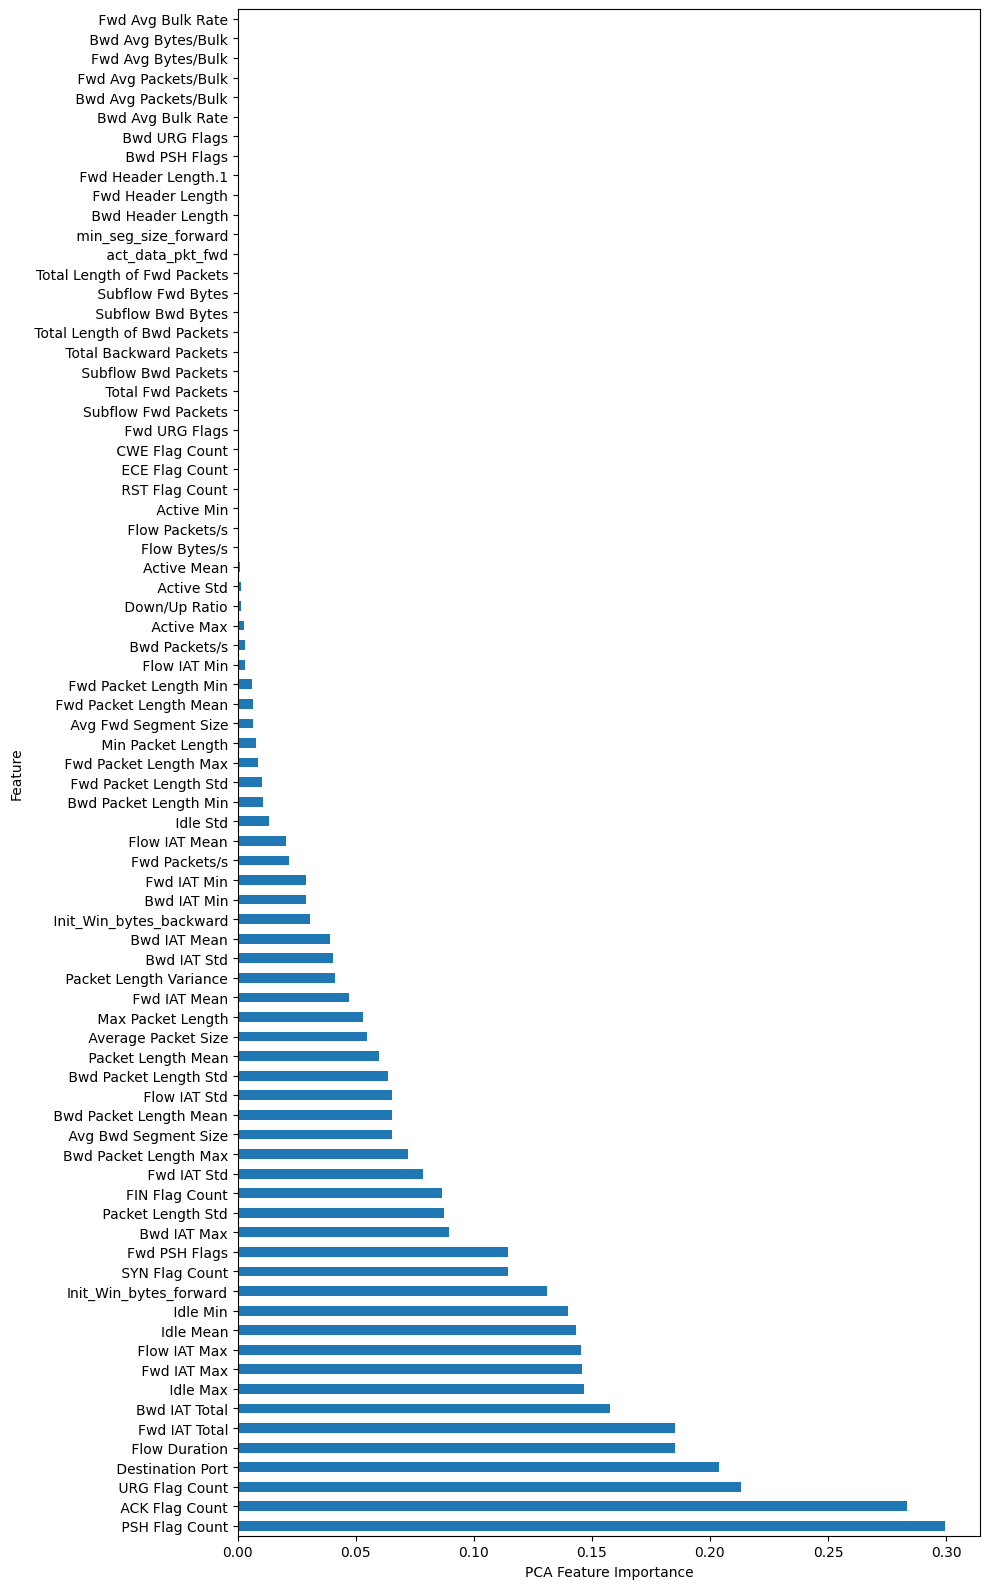

In [ ]:
cic_ids_feature_importance_pca_df.plot(
    x='feature',
    y='importance',
    kind='barh',
    legend=False,
    figsize=(10, 16)
)
plt.xlabel("PCA Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Summary

To summarize we encoded every column as numbers (with LabelEncoder) and replaced null values with the biggest possible float number and also positive infinity numbers with the max possible float. Also we droped duplicates. Then we encoded everything into numbers and normalized the numbers. Last but not least we checked the feature importance

In [ ]:
# Data we can continue with:
# -> cic_ids_X_train_scaled -> cic_ids_y_train
# -> cic_ids_X_test_scaled -> cic_ids_y_test
cic_ids_mapping = {cls: idx for idx, cls in enumerate(cic_ids_label_encoders[' Label'].classes_)}
print(cic_ids_mapping)

{'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


## Merge Datasets

In [ ]:
def preprocess_nslkdd(df):
    cols_map = {
        'duration': 'duration',
        'src_bytes': 'src_bytes',
        'dst_bytes': 'dst_bytes',
        'count': 'count',
        'urgent': 'urgent',
        'attack': 'label'
    }

    df = df[list(cols_map.keys())].rename(columns=cols_map)
    nslkdd_mapping = {cls: idx for idx, cls in enumerate(nslkdd_label_encoders['attack'].classes_)}
    nslkdd_label_mapping_reverse = {idx: cls  for idx, cls in enumerate(nslkdd_label_encoders['attack'].classes_)}
    df['label'] = df['label'].apply(lambda x: nslkdd_label_mapping_reverse[x])
    return df


def preprocess_cicids(df):
    cic_map = {
        ' Flow Duration': 'duration',
        'Total Length of Fwd Packets': 'src_bytes',
        ' Total Length of Bwd Packets': 'dst_bytes',
        ' Total Fwd Packets': 'count',
        ' Fwd URG Flags': 'urgent',
        ' Label': 'label'
    }
    df = df[list(cic_map.keys())].rename(columns=cic_map)
    cic_ids_label_mapping_reverse = {idx: cls  for idx, cls in enumerate(cic_ids_label_encoders[' Label'].classes_)}
    df['label'] = df['label'].apply(lambda x: cic_ids_label_mapping_reverse[x])
    return df

nslkdd_mapped = preprocess_nslkdd(nslkdd_full_data)
cicids_mapped = preprocess_cicids(cic_ids_data)

columns = ['duration', 'src_bytes', 'dst_bytes', 'count', 'urgent', 'label',]
nslkdd_mapped = nslkdd_mapped.reindex(columns=columns)
cicids_mapped = cicids_mapped.reindex(columns=columns)
merged_datasets = pd.concat([nslkdd_mapped, cicids_mapped], ignore_index=True)

print(len(merged_datasets))
merged_datasets.head()

2670879


,duration,src_bytes,dst_bytes,count,urgent,label
0,0,491,0,2,0,normal
1,0,146,0,13,0,normal
2,0,0,0,123,0,neptune
3,0,232,8153,5,0,normal
4,0,199,420,30,0,normal


In [ ]:
merged_datasets_label_encoders = {}
for column in ['label']:
    le = LabelEncoder()
    merged_datasets[column] = le.fit_transform(merged_datasets[column])
    merged_datasets_label_encoders[column] = le

In [ ]:
merged_datasets_X = merged_datasets.drop(['label'], axis=1)
merged_datasets_y = merged_datasets['label']

merged_datasets_X_train, merged_datasets_X_test, merged_datasets_y_train, merged_datasets_y_test = train_test_split(merged_datasets_X, merged_datasets_y, test_size=0.2, random_state=42)

In [ ]:
merged_datasets_pca = PCA(n_components=min(10, merged_datasets_X.shape[1]))
merged_datasets_pca.fit(merged_datasets_X)

merged_datasets_components = pd.DataFrame(
    np.abs(merged_datasets_pca.components_),
    columns=merged_datasets_X_train.columns
)

merged_datasets_feature_importance_pca = merged_datasets_components.mean(axis=0).sort_values(ascending=False)

merged_datasets_explained_variance_ratio = merged_datasets_pca.explained_variance_ratio_
merged_datasets_feature_importance_weighted = (merged_datasets_components.T @ merged_datasets_explained_variance_ratio).sort_values(ascending=False)

merged_datasets_feature_importance_pca_df = pd.DataFrame({
    'feature': merged_datasets_feature_importance_weighted.index,
    'importance': merged_datasets_feature_importance_weighted.values
})

print(merged_datasets_feature_importance_pca_df)

     feature    importance
0   duration  9.934584e-01
1  dst_bytes  6.261264e-03
2  src_bytes  1.383014e-03
3      count  1.904914e-06
4     urgent  5.409360e-13


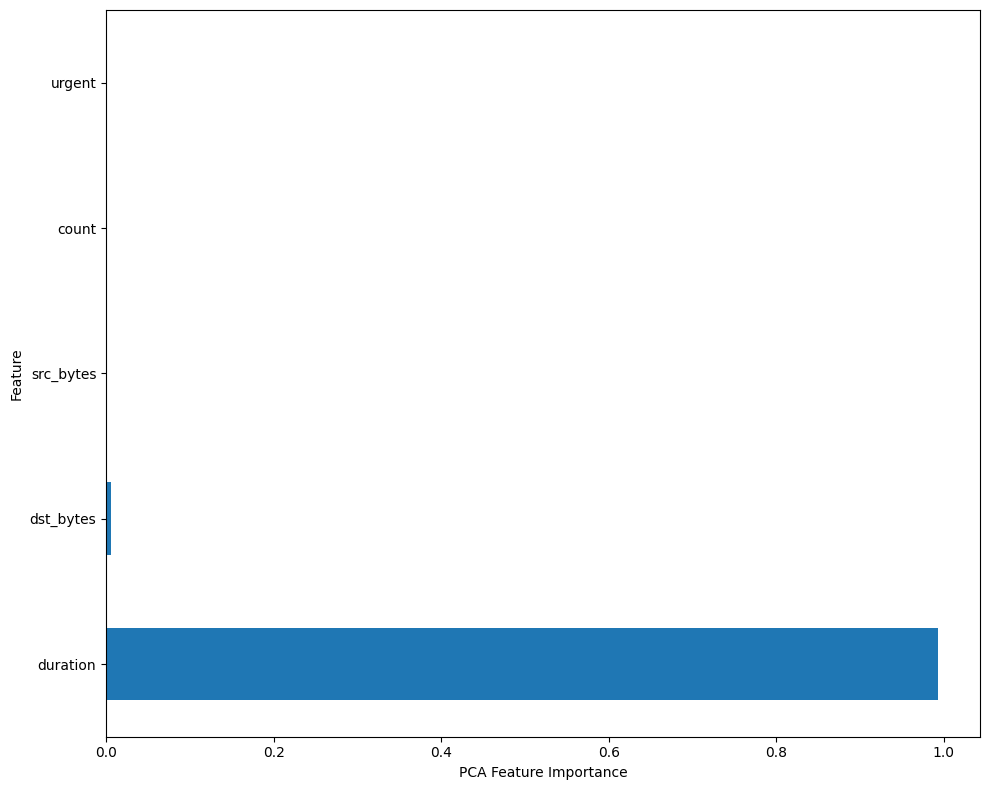

In [ ]:
merged_datasets_feature_importance_pca_df.plot(
    x='feature',
    y='importance',
    kind='barh',
    legend=False,
    figsize=(10, 8)
)
plt.xlabel("PCA Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Creating a Model

@article{\
    author = {Hassan Gharoun, Fereshteh Momenifar, Fang Chen, Amir H. Gandomi},\
    title = {Meta-learning approaches for few-shot learning: A survey of recent advances},\
    journal = {arXiv},\
    url = {https://arxiv.org/abs/2303.07502}, \
    urldate = {2025},\
    year = {2023}\
}

In [ ]:
# NSL-KDD 2009 Dataset:
# There are 41 features, along with a label column and a difficulty level column, making a total of 43 columns.
# -> nslkdd_X_train_scaled -> nslkdd_y_train
# -> nslkdd_X_test_scaled -> nslkdd_y_test

nslkdd_label_mapping = {cls: idx for idx, cls in enumerate(nslkdd_label_encoders['attack'].classes_)}
print(nslkdd_label_mapping)


# CIC-IDS- 2017 Dataset:
# There are 78 features, along with a label column, making a total of 79 columns.
# -> cic_ids_X_train_scaled -> cic_ids_y_train
# -> cic_ids_X_test_scaled -> cic_ids_y_test
cic_ids_label_mapping = {cls: idx for idx, cls in enumerate(cic_ids_label_encoders[' Label'].classes_)}
print(cic_ids_label_mapping)

{'apache2': 0, 'back': 1, 'buffer_overflow': 2, 'ftp_write': 3, 'guess_passwd': 4, 'httptunnel': 5, 'imap': 6, 'ipsweep': 7, 'land': 8, 'loadmodule': 9, 'mailbomb': 10, 'mscan': 11, 'multihop': 12, 'named': 13, 'neptune': 14, 'nmap': 15, 'normal': 16, 'perl': 17, 'phf': 18, 'pod': 19, 'portsweep': 20, 'processtable': 21, 'ps': 22, 'rootkit': 23, 'saint': 24, 'satan': 25, 'sendmail': 26, 'smurf': 27, 'snmpgetattack': 28, 'snmpguess': 29, 'spy': 30, 'sqlattack': 31, 'teardrop': 32, 'udpstorm': 33, 'warezclient': 34, 'warezmaster': 35, 'worm': 36, 'xlock': 37, 'xsnoop': 38, 'xterm': 39}
{'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


## DNN

In [ ]:
nslkdd_num_lables = max(nslkdd_y_train) + 1
nslkdd_y_train_ohe = to_categorical(nslkdd_y_train)

In [ ]:
def create_dnn(num_classes: int, input_shape: int) -> Sequential:
  dropout: int = 0.3
  init_layer: int = 128
  model = Sequential([
    Dense(init_layer, activation='relu', input_shape=(input_shape,)),
    Dropout(dropout),
    Dense(int(init_layer / 2), activation='relu'),
    Dropout(dropout),
    Dense(int(init_layer / 4), activation='relu'),
    Dense(num_classes, activation='softmax')
  ])

  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
  model.summary()
  return model

In [ ]:
def train_model(model: Sequential, name: str, x_train, y_train, epochs: int=100, batch_size: int=128) -> object:
  folder_name: str = 'checkpoints'
  os.makedirs(folder_name, exist_ok=True)

  #es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)
  mc = ModelCheckpoint(filepath=f'{folder_name}/{name}_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

  history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[mc],
    verbose=2
  )

  return history

## Train on NSL-KDD

In [ ]:
EPOCHS: int = 100
BATCH_SIZE: int = 128

model_nslkdd = create_dnn(nslkdd_num_lables, nslkdd_X_train_scaled.shape[1])
history_nslkdd = train_model(model_nslkdd, 'nslkdd', nslkdd_X_train_scaled, nslkdd_y_train_ohe, EPOCHS, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         1,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,032 (66.53 KB)

 Trainable params: 17,032 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.93713, saving model to checkpoints/nslkdd_best_model.keras
743/743 - 7s - 10ms/step - accuracy: 0.8921 - loss: 0.5121 - val_accuracy: 0.9371 - val_loss: 0.2203
Epoch 2/100

Epoch 2: val_accuracy improved from 0.93713 to 0.95051, saving model to checkpoints/nslkdd_best_model.keras
743/743 - 2s - 3ms/step - accuracy: 0.9359 - loss: 0.2216 - val_accuracy: 0.9505 - val_loss: 0.1551
Epoch 3/100

Epoch 3: val_accuracy improved from 0.95051 to 0.96562, saving model to checkpoints/nslkdd_best_model.keras
743/743 - 2s - 3ms/step - accuracy: 0.9474 - loss: 0.1726 - val_accuracy: 0.9656 - val_loss: 0.1205
Epoch 4/100

Epoch 4: val_accuracy improved from 0.96562 to 0.96953, saving model to checkpoints/nslkdd_best_model.keras
743/743 - 2s - 2ms/step - accuracy: 0.9563 - loss: 0.1442 - val_accuracy: 0.9695 - val_loss: 0.1067
Epoch 5/100

Epoch 5: val_accuracy improved from 0.96953 to 0.97176, saving model to checkpoints/nslkdd_best_model.ker

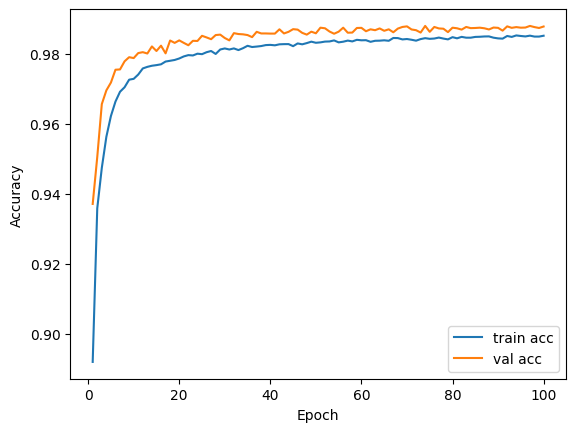

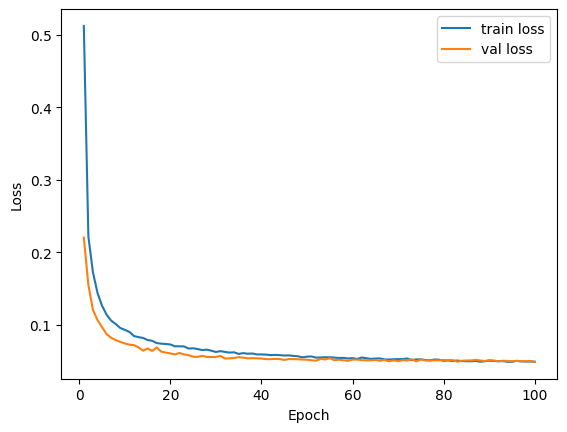

In [ ]:
hist_nsl = history_nslkdd.history

epochs = range(1, len(hist_nsl['loss'])+1)

plt.plot(epochs, hist_nsl['accuracy'], label='train acc')
plt.plot(epochs, hist_nsl['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, hist_nsl['loss'], label='train loss')
plt.plot(epochs, hist_nsl['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Train on CIC-IDS

In [ ]:
cic_ids_num_lables = max(cic_ids_y_train) + 1
cic_ids_y_train_ohe = to_categorical(cic_ids_y_train)

EPOCHS: int = 100
BATCH_SIZE: int = 512

model_cicids = create_dnn(cic_ids_num_lables, cic_ids_X_train_scaled.shape[1])
history_cicids = train_model(model_cicids, 'cicids', cic_ids_X_train_scaled, cic_ids_y_train_ohe, EPOCHS, BATCH_SIZE)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,943 (81.81 KB)

 Trainable params: 20,943 (81.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.97066, saving model to checkpoints/cicids_best_model.keras
3153/3153 - 14s - 4ms/step - accuracy: 0.9533 - loss: 0.1467 - val_accuracy: 0.9707 - val_loss: 0.0690
Epoch 2/100

Epoch 2: val_accuracy improved from 0.97066 to 0.97606, saving model to checkpoints/cicids_best_model.keras
3153/3153 - 8s - 2ms/step - accuracy: 0.9715 - loss: 0.0695 - val_accuracy: 0.9761 - val_loss: 0.0509
Epoch 3/100

Epoch 3: val_accuracy improved from 0.97606 to 0.97893, saving model to checkpoints/cicids_best_model.keras
3153/3153 - 8s - 2ms/step - accuracy: 0.9756 - loss: 0.0561 - val_accuracy: 0.9789 - val_loss: 0.0452
Epoch 4/100

Epoch 4: val_accuracy improved from 0.97893 to 0.98095, saving model to checkpoints/cicids_best_model.keras
3153/3153 - 8s - 2ms/step - accuracy: 0.9775 - loss: 0.0495 - val_accuracy: 0.9809 - val_loss: 0.0406
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.98095
3153/3153 - 8s - 3ms/step - accuracy: 0.9787 -

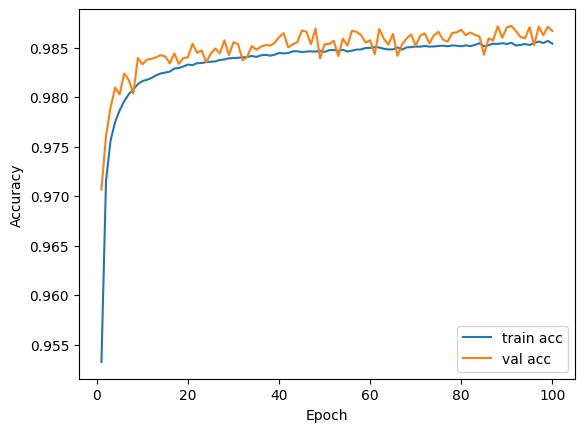

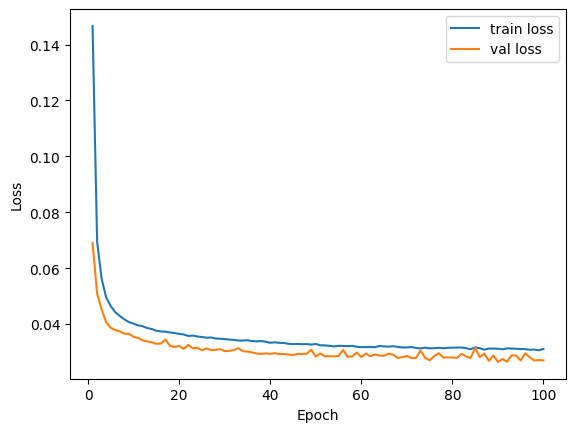

In [ ]:
hist_cic = history_cicids.history

epochs = range(1, len(hist_cic['loss'])+1)

plt.plot(epochs, hist_cic['accuracy'], label='train acc')
plt.plot(epochs, hist_cic['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, hist_cic['loss'], label='train loss')
plt.plot(epochs, hist_cic['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train Merged on merged Datasets

In [ ]:
merged_datasets_num_lables = max(merged_datasets_y_train) + 1
merged_datasets_y_train_ohe = to_categorical(merged_datasets_y_train)

EPOCHS: int = 100
BATCH_SIZE: int = 512

model_merged_datasets = create_dnn(merged_datasets_num_lables, merged_datasets_X_train.shape[1])
history_merged_datasets = train_model(model_merged_datasets, 'merged_datasets', merged_datasets_X_train, merged_datasets_y_train_ohe, EPOCHS, BATCH_SIZE)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 55)             │         1,815 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,919 (50.46 KB)

 Trainable params: 12,919 (50.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.80067, saving model to checkpoints/merged_datasets_best_model.keras
3339/3339 - 14s - 4ms/step - accuracy: 0.7477 - loss: 12586.9023 - val_accuracy: 0.8007 - val_loss: 0.9733
Epoch 2/100

Epoch 2: val_accuracy improved from 0.80067 to 0.80400, saving model to checkpoints/merged_datasets_best_model.keras
3339/3339 - 8s - 2ms/step - accuracy: 0.7992 - loss: 23.2827 - val_accuracy: 0.8040 - val_loss: 0.8364
Epoch 3/100

Epoch 3: val_accuracy improved from 0.80400 to 0.81469, saving model to checkpoints/merged_datasets_best_model.keras
3339/3339 - 8s - 2ms/step - accuracy: 0.8047 - loss: 2.2227 - val_accuracy: 0.8147 - val_loss: 0.7431
Epoch 4/100

Epoch 4: val_accuracy improved from 0.81469 to 0.83068, saving model to checkpoints/merged_datasets_best_model.keras
3339/3339 - 8s - 2ms/step - accuracy: 0.8145 - loss: 1.4787 - val_accuracy: 0.8307 - val_loss: 0.7075
Epoch 5/100

Epoch 5: val_accuracy improved from 0.83068 to 0.84056, 

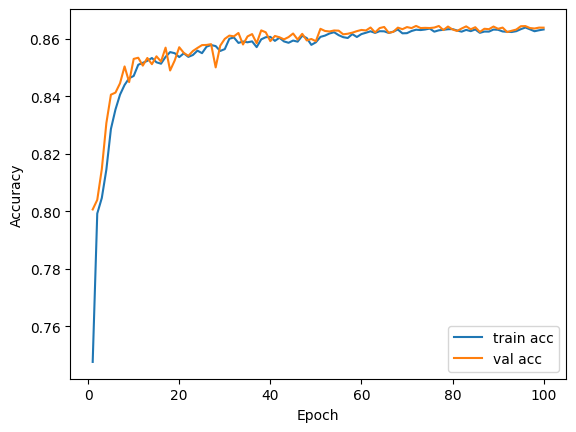

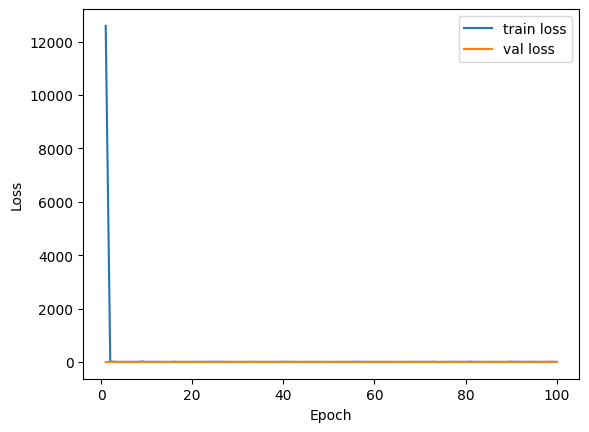

In [ ]:
hist_merged_datasets = history_merged_datasets.history

epochs = range(1, len(hist_merged_datasets['loss'])+1)

plt.plot(epochs, hist_merged_datasets['accuracy'], label='train acc')
plt.plot(epochs, hist_merged_datasets['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, hist_merged_datasets['loss'], label='train loss')
plt.plot(epochs, hist_merged_datasets['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

In [ ]:
def evaluate_classification_metrics(y_true, y_pred_probs):
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # Get predicted classes
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    n_classes = y_pred_probs.shape[1]
    labels = np.arange(n_classes)

    accuracy = accuracy_score(y_true, y_pred_classes)

    recall_macro = recall_score(y_true, y_pred_classes, average='macro', zero_division=0, labels=labels)
    precision_macro = precision_score(y_true, y_pred_classes, average='macro', zero_division=0, labels=labels)
    f1_macro = f1_score(y_true, y_pred_classes, average='macro', zero_division=0, labels=labels)

    recall_weighted = recall_score(y_true, y_pred_classes, average='weighted', zero_division=0, labels=labels)
    precision_weighted = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0, labels=labels)
    f1_weighted = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0, labels=labels)

    print("Classification Metrics:")
    print(f"Accuracy:           {accuracy:.3f}")
    print(f"\nMacro Averages:")
    print(f"  Recall:           {recall_macro:.3f}")
    print(f"  Precision:        {precision_macro:.3f}")
    print(f"  F1-score:         {f1_macro:.3f}")
    print(f"\nWeighted Averages:")
    print(f"  Recall:           {recall_weighted:.3f}")
    print(f"  Precision:        {precision_weighted:.3f}")
    print(f"  F1-score:         {f1_weighted:.3f}")

In [ ]:
y_pred_probs_y_cic = model_cicids.predict(cic_ids_X_test_scaled)
evaluate_classification_metrics(cic_ids_y_test, y_pred_probs_y_cic)

15765/15765 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
Classification Metrics:
Accuracy:           0.987

Macro Averages:
  Recall:           0.644
  Precision:        0.848
  F1-score:         0.678

Weighted Averages:
  Recall:           0.987
  Precision:        0.987
  F1-score:         0.986


In [ ]:
y_pred_probs_y_nslkdd = model_nslkdd.predict(nslkdd_X_test_scaled)
evaluate_classification_metrics(nslkdd_y_test, y_pred_probs_y_nslkdd)

929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Metrics:
Accuracy:           0.986

Macro Averages:
  Recall:           0.559
  Precision:        0.586
  F1-score:         0.548

Weighted Averages:
  Recall:           0.986
  Precision:        0.986
  F1-score:         0.985


In [ ]:
y_pred_probs = model_merged_datasets.predict(merged_datasets_X_test)
evaluate_classification_metrics(merged_datasets_y_test, y_pred_probs)

16693/16693 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
Classification Metrics:
Accuracy:           0.864

Macro Averages:
  Recall:           0.158
  Precision:        0.207
  F1-score:         0.159

Weighted Averages:
  Recall:           0.864
  Precision:        0.814
  F1-score:         0.805


## Auto Encoder

@article{\
    author = {Hanan Hindy, Robert Atkinson, Christos Tachtatzis, Jean-Noël Colin, Ethan Bayne and Xavier Bellekens},\
    title = {Utilising Deep Learning Techniques for Effective Zero-Day Attack Detection},\
    journal = {arXiv},\
    url = {https://arxiv.org/pdf/2006.15344}, \
    urldate = {2025},\
    year = {2020}\
}

In [ ]:
cic_ids_y_train.unique()

array([ 4,  0,  2, 10,  3,  5, 12,  6,  1,  7, 11, 13, 14,  8,  9])

In [ ]:
print(nslkdd_label_mapping)
print(cic_ids_label_mapping)

{'apache2': 0, 'back': 1, 'buffer_overflow': 2, 'ftp_write': 3, 'guess_passwd': 4, 'httptunnel': 5, 'imap': 6, 'ipsweep': 7, 'land': 8, 'loadmodule': 9, 'mailbomb': 10, 'mscan': 11, 'multihop': 12, 'named': 13, 'neptune': 14, 'nmap': 15, 'normal': 16, 'perl': 17, 'phf': 18, 'pod': 19, 'portsweep': 20, 'processtable': 21, 'ps': 22, 'rootkit': 23, 'saint': 24, 'satan': 25, 'sendmail': 26, 'smurf': 27, 'snmpgetattack': 28, 'snmpguess': 29, 'spy': 30, 'sqlattack': 31, 'teardrop': 32, 'udpstorm': 33, 'warezclient': 34, 'warezmaster': 35, 'worm': 36, 'xlock': 37, 'xsnoop': 38, 'xterm': 39}
{'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


In [ ]:
# Training should be done on normal traffic patterns.
# So it is essential to train the model ONLY on normal recors.
normal_indices_nslkdd = np.where(nslkdd_y_train == 16)[0]  # 16 -> normal
X_train_nslkdd_normal = nslkdd_X_train_scaled[normal_indices_nslkdd]

normal_indices_cicids = np.where(cic_ids_y_train == 0)[0]  # 0 -> BENIGN
X_train_cicids_normal = cic_ids_X_train_scaled[normal_indices_cicids]

In [ ]:
# Create the encoder's architecture based on the paper
def encoder(input_dim: int) -> Model:
  encoder = Sequential([
      Input(shape=(input_dim,)),
      Dense(64, activation='relu', activity_regularizer=regularizers.l2(0.001)),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(32, activation='relu'),
      Dense(64, activation='relu'),
      Dense(input_dim, activation='sigmoid')
  ])

  encoder.compile(optimizer='adam', loss='mae')
  return encoder

In [ ]:
# Train Autoencoder on both datasets
EPOCH: int = 40
BATCH: int = 1024

ae_nslkdd = encoder(X_train_nslkdd_normal.shape[1])  # input -> 41
ae_nslkdd.fit(X_train_nslkdd_normal, X_train_nslkdd_normal, epochs=EPOCH, batch_size=BATCH,
              shuffle=True, validation_split=0.1, verbose=2)

ae_cicids = encoder(X_train_cicids_normal.shape[1])  # input -> 78
ae_cicids.fit(X_train_cicids_normal, X_train_cicids_normal, epochs=EPOCH, batch_size=BATCH,
              shuffle=True, validation_split=0.1, verbose=2)

Epoch 1/40
55/55 - 5s - 87ms/step - loss: 1.3852 - val_loss: 0.3621
Epoch 2/40
55/55 - 0s - 4ms/step - loss: 0.1846 - val_loss: 0.1002
Epoch 3/40
55/55 - 0s - 4ms/step - loss: 0.0783 - val_loss: 0.0647
Epoch 4/40
55/55 - 0s - 3ms/step - loss: 0.0592 - val_loss: 0.0564
Epoch 5/40
55/55 - 0s - 3ms/step - loss: 0.0541 - val_loss: 0.0535
Epoch 6/40
55/55 - 0s - 4ms/step - loss: 0.0520 - val_loss: 0.0522
Epoch 7/40
55/55 - 0s - 4ms/step - loss: 0.0511 - val_loss: 0.0515
Epoch 8/40
55/55 - 0s - 3ms/step - loss: 0.0505 - val_loss: 0.0511
Epoch 9/40
55/55 - 0s - 4ms/step - loss: 0.0501 - val_loss: 0.0510
Epoch 10/40
55/55 - 0s - 4ms/step - loss: 0.0499 - val_loss: 0.0509
Epoch 11/40
55/55 - 0s - 4ms/step - loss: 0.0497 - val_loss: 0.0504
Epoch 12/40
55/55 - 0s - 4ms/step - loss: 0.0497 - val_loss: 0.0504
Epoch 13/40
55/55 - 0s - 4ms/step - loss: 0.0496 - val_loss: 0.0503
Epoch 14/40
55/55 - 0s - 3ms/step - loss: 0.0495 - val_loss: 0.0503
Epoch 15/40
55/55 - 0s - 3ms/step - loss: 0.0494 - val_l

In [ ]:
# Calculate the reconstruction error (from training)
re_nslkdd = ae_nslkdd.predict(X_train_nslkdd_normal)
train_loss_nslkdd = np.mean(np.abs(re_nslkdd - X_train_nslkdd_normal), axis=1)
threshold_nslkdd = np.mean(train_loss_nslkdd) + 3 * np.std(train_loss_nslkdd)

re_cicids = ae_cicids.predict(X_train_cicids_normal)
train_loss_cicids = np.mean(np.abs(re_cicids - X_train_cicids_normal), axis=1)
threshold_cicids = np.mean(train_loss_cicids) + 3 * np.std(train_loss_cicids)

1926/1926 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
52425/52425 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step


In [ ]:
# Evaluate on test
re_nslkdd = ae_nslkdd.predict(nslkdd_X_test_scaled)
test_loss_nslkdd = np.mean(np.abs(re_nslkdd - nslkdd_X_test_scaled), axis=1)
y_pred_nslkdd = (test_loss_nslkdd > threshold_nslkdd).astype(int)
y_true_nslkdd = (nslkdd_y_test != 'normal').astype(int)

print("NSL-KDD:")
print(classification_report(y_true_nslkdd, y_pred_nslkdd))
# this was about 76% accuracy :(

re_cicids = ae_cicids.predict(cic_ids_X_test_scaled)
test_loss_cicids = np.mean(np.abs(re_cicids - cic_ids_X_test_scaled), axis=1)
y_pred_cicids = (test_loss_cicids > threshold_cicids).astype(int)
y_true_cicids = (cic_ids_y_test != 'BENIGN').astype(int)

print("CICIDS:")
print(classification_report(y_true_cicids, y_pred_cicids))
# this was low as hell [about 9%], so prob the 'normal_indices_cicids' is not good

929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NSL-KDD:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.36      0.53     29704

    accuracy                           0.36     29704
   macro avg       0.50      0.18      0.27     29704
weighted avg       1.00      0.36      0.53     29704



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15765/15765 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
CICIDS:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.09      0.17    504473

    accuracy                           0.09    504473
   macro avg       0.50      0.05      0.09    504473
weighted avg       1.00      0.09      0.17    504473



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
